# MODELS

Here is all code related to all the models we will be testing for. We have a total of 6 different models, alongside different datasets we tried out, due to the various encoders we used. Below is a description of them.

## ENCODINGS
The encodings we have used so far are:
- Count Encoding
- CatBoost Encoding

The reason we didn't opt for One-Hot Encoding (even though it would work great for our categorical features) is because it would result in high number of dimesions, resulting in the curse of dimensionality.

Also, our original problem is regression due to the ratings type, however, we deducted we would benefit from a classification problem instead, since it allows us better margins, since predicting accurately the exact rating would be near impossible to mimic. In that context, we tried to bin the ratings with different number of bins (between 3 to 5 bins). After some thinking, we decided 3 was the best number of bins to get the best accurate predictions possible, while making it a user-understandable bin size (i.e. low, medium, high).

## MODELS
Here are the 6 Sklearn Models we have tried and tested:
- Decision Tree
- Gradient Boosting
- kNN
- Logistic Regression
- Naive Bayes
  - Multinomial
  - Categorical
  - Gaussian
- Random Forest

As of now, we have seen Random Forest produce the best results out of all models. We are currently looking at F1-scores and weighted avg score, due to the mere fact the nature of our problem deals with a class imbalance, since ratings follows a normal distribution with the mean center around 5-6 between 0-10.

In [57]:
from utils import *

In [58]:
# READ DATA
df = pd.read_pickle("../../datasets/pickle/processed_action_movie_data.pkl")
X, y = df.drop("rating", axis=1), df['rating']

In [59]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# ENCODE DATA
y_train, y_test = rating_encoding(y_train), rating_encoding(y_test)
X_train, X_test = catboost_encoding(X_train, X_test, y_train, y_test)

In [61]:
# EVAULATION FUNCTIONS
def evaluate(y_test, y_pred):
    report = classification_report(y_test, y_pred, zero_division=0)
    print(f"Classification Report:\n", report)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n")
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # Print the results
    print("True Positive Rate (TPR): ", TPR)
    print("False Positive Rate (FPR): ", FPR)
    # False discovery rate
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
def roc_auc(clf, y_train, X_test, y_test):
    # Plot all OvR ROC curves together
    y_score = clf.predict_proba(X_test)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    n_classes = len(y_test.unique())

    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    fig, ax = plt.subplots(figsize=(6, 6))
 
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(['red', 'orange', 'green', 'blue', 'purple'])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {class_id}",
            color=color,
            ax=ax,
        )
    macro_fpr = sum(fpr.values()) / 3
    macro_tpr = sum(tpr.values()) / 3
    macro_roc_auc= auc(macro_fpr, macro_tpr)
    print("FPR ", macro_fpr)
    print("TPR ", macro_tpr)
    print("auc ", macro_roc_auc)
    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC OvR for {clf.__class__.__name__}")
    plt.legend()
    plt.show()

In [62]:
# MODEL FUNCTIONS
def dt(X_train, X_test, y_train, y_test):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=7)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluate(y_test, y_pred)
    roc_auc(clf, y_train, X_test, y_test)

def gboost(X_train, X_test, y_train, y_test):
    clf = GradientBoostingClassifier(learning_rate=0.5, max_depth=3, n_estimators=40)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluate(y_test, y_pred)
    roc_auc(clf, y_train, X_test, y_test)

def knn(X_train, X_test, y_train, y_test):
    # SCALING
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = KNeighborsClassifier(n_neighbors=12, p=1, weights='uniform')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    evaluate(y_test, y_pred)
    roc_auc(clf, y_train, X_test, y_test)

def lr(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(solver= 'newton-cg', penalty= 'l2', C= 10)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluate(y_test, y_pred)
    roc_auc(clf, y_train, X_test, y_test)

def mnb(X_train, X_test, y_train, y_test):
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluate(y_test, y_pred)
    roc_auc(clf, y_train, X_test, y_test)

def cnb(X_train, X_test, y_train, y_test):
    clf = CategoricalNB(fit_prior=False)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluate(y_test, y_pred)
    roc_auc(clf, y_train, X_test, y_test)

def gnb(X_train, X_test, y_train, y_test):
    clf = GaussianNB(priors= None, var_smoothing= 1e-07)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluate(y_test, y_pred)
    roc_auc(clf, y_train, X_test, y_test)


def rf(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=700, min_samples_split= 3, min_samples_leaf= 3, max_features= 'sqrt', max_depth= None)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluate(y_test, y_pred)
    roc_auc(clf, y_train, X_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.25      0.36       132
           1       0.73      0.93      0.81       890
           2       0.65      0.30      0.41       308

    accuracy                           0.72      1330
   macro avg       0.68      0.49      0.53      1330
weighted avg       0.70      0.72      0.68      1330

Confusion Matrix:

True Positive Rate (TPR):  [0.25       0.92808989 0.30194805]
False Positive Rate (FPR):  [0.01335559 0.70909091 0.04892368]


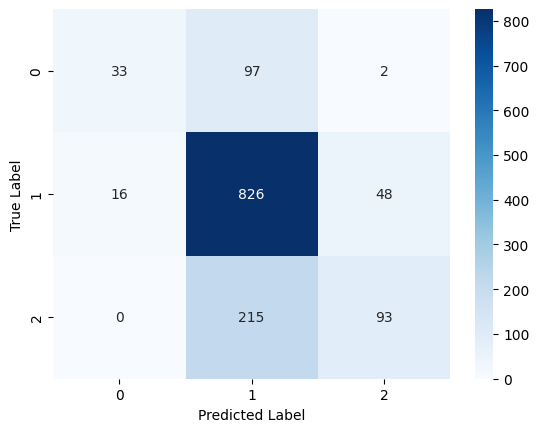

FPR  [0.         0.00100251 0.00137845 0.00150376 0.00150376 0.00175439
 0.0018797  0.0018797  0.00200501 0.00200501 0.00213033 0.00263158
 0.01829574 0.01867168 0.02807018 0.02807018 0.02907268 0.02907268
 0.03157895 0.03546366 0.03546366 0.03621554 0.03646617 0.03721805
 0.04172932 0.04736842 0.04786967 0.04786967 0.05137845 0.05175439
 0.05325815 0.05338346 0.0593985  0.06290727 0.06353383 0.06478697
 0.06491228 0.07518797 0.07606516 0.07656642 0.07794486 0.09586466
 0.09649123 0.14636591 0.19536341 0.19536341 0.20626566 0.20676692
 0.20701754 0.23132832 0.23145363 0.23170426 0.24461153 0.24511278
 0.2481203  0.2556391  0.26616541 0.27656642 0.33333333]
TPR  [0.         0.03383459 0.05438596 0.060401   0.06140351 0.06190476
 0.06190476 0.06290727 0.06290727 0.06315789 0.06441103 0.06716792
 0.15037594 0.15213033 0.18496241 0.18521303 0.1877193  0.18897243
 0.19598997 0.21528822 0.21553885 0.21854637 0.21929825 0.22030075
 0.22681704 0.23809524 0.239599   0.24010025 0.24862155 0.2491

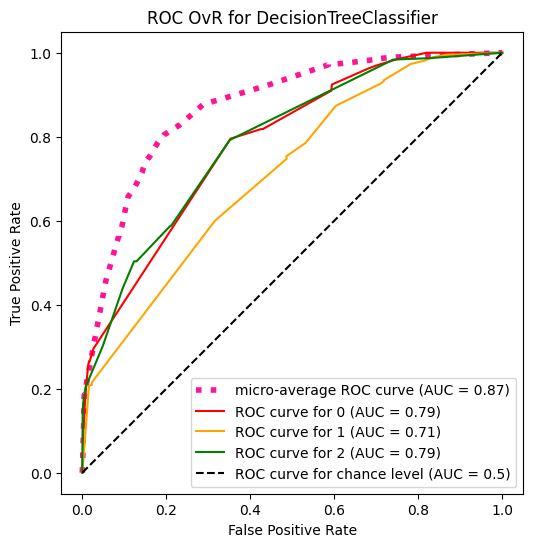

In [63]:
dt(X_train, X_test, y_train, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.21      0.32       132
           1       0.73      0.93      0.82       890
           2       0.68      0.35      0.46       308

    accuracy                           0.72      1330
   macro avg       0.68      0.50      0.53      1330
weighted avg       0.71      0.72      0.69      1330

Confusion Matrix:

True Positive Rate (TPR):  [0.21212121 0.93033708 0.3474026 ]
False Positive Rate (FPR):  [0.01419032 0.68181818 0.04892368]


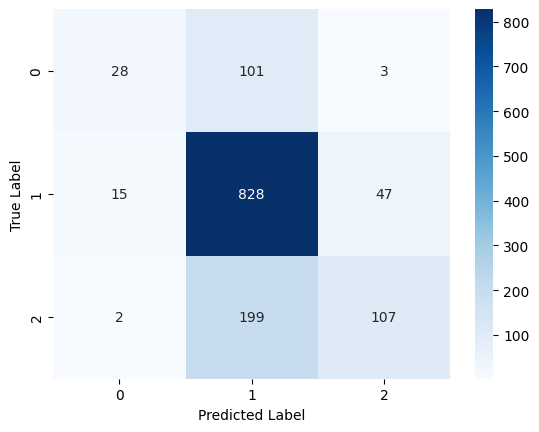

FPR  [0.         0.         0.         ... 0.32669173 0.32694236 0.33333333]
TPR  [0.00000000e+00 2.50626566e-04 2.25563910e-03 ... 3.33333333e-01
 3.33333333e-01 3.33333333e-01]
auc  0.09782953624663161


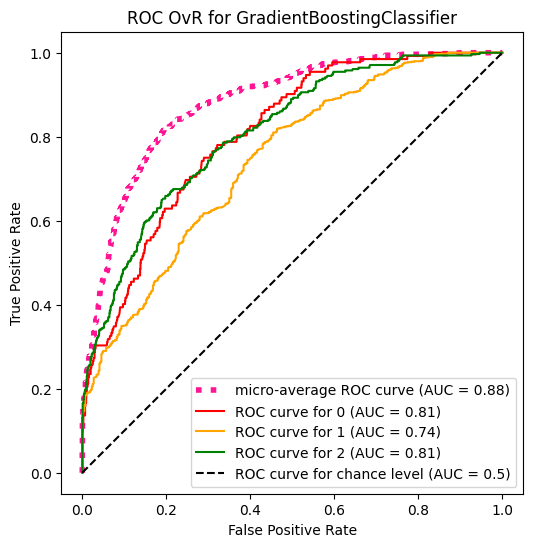

In [64]:
gboost(X_train, X_test, y_train, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.23      0.34       132
           1       0.73      0.93      0.82       890
           2       0.70      0.33      0.45       308

    accuracy                           0.72      1330
   macro avg       0.67      0.50      0.53      1330
weighted avg       0.71      0.72      0.68      1330

Confusion Matrix:

True Positive Rate (TPR):  [0.23484848 0.92808989 0.33116883]
False Positive Rate (FPR):  [0.01836394 0.69318182 0.04305284]


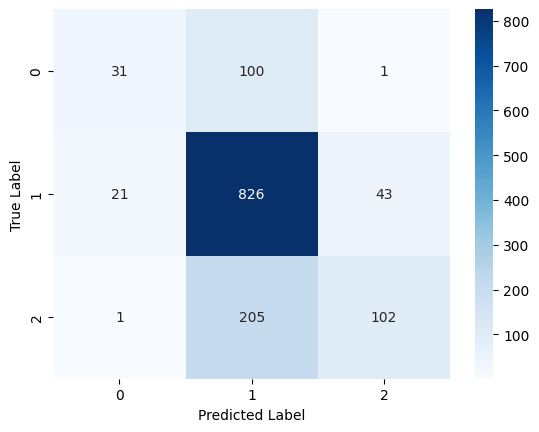

FPR  [0.         0.00087719 0.00313283 0.00814536 0.01679198 0.02493734
 0.03546366 0.0481203  0.06303258 0.08508772 0.11265664 0.15651629
 0.21929825 0.33333333]
TPR  [0.         0.02781955 0.05964912 0.10300752 0.14285714 0.18120301
 0.21328321 0.24210526 0.2641604  0.28145363 0.29749373 0.31428571
 0.3245614  0.33333333]
auc  0.09661319652514744


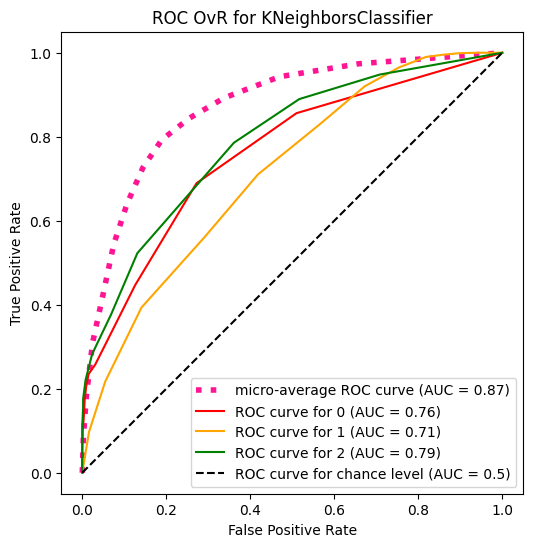

In [65]:
knn(X_train, X_test, y_train, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.17      0.28       132
           1       0.72      0.95      0.82       890
           2       0.71      0.30      0.42       308

    accuracy                           0.72      1330
   macro avg       0.73      0.48      0.51      1330
weighted avg       0.73      0.72      0.68      1330

Confusion Matrix:

True Positive Rate (TPR):  [0.17424242 0.95280899 0.2987013 ]
False Positive Rate (FPR):  [0.00584307 0.73409091 0.03620352]


/Users/gautamsapre/.pyenv/versions/3.10.11/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/gautamsapre/.pyenv/versions/3.10.11/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/gautamsapre/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


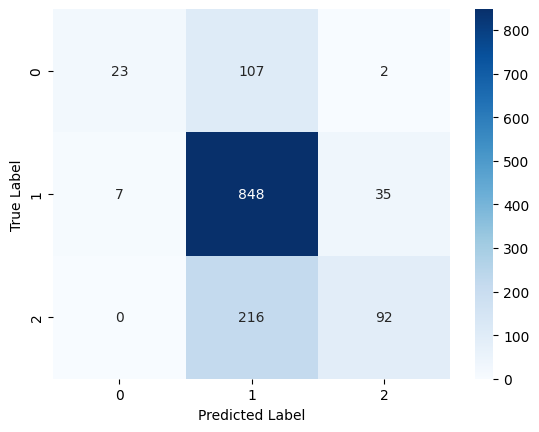

FPR  [0.         0.         0.         ... 0.31616541 0.31616541 0.33333333]
TPR  [0.00000000e+00 2.50626566e-04 9.02255639e-03 ... 3.33082707e-01
 3.33333333e-01 3.33333333e-01]
auc  0.09573011476058567


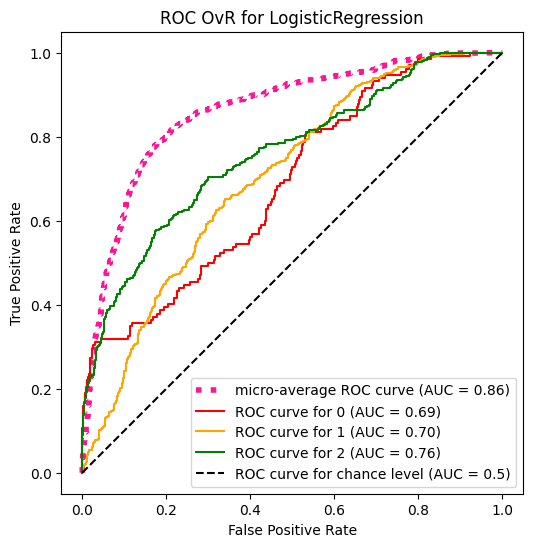

In [66]:
lr(X_train, X_test, y_train, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.08      0.12       132
           1       0.71      0.61      0.66       890
           2       0.31      0.51      0.38       308

    accuracy                           0.53      1330
   macro avg       0.41      0.40      0.39      1330
weighted avg       0.57      0.53      0.54      1330

Confusion Matrix:

True Positive Rate (TPR):  [0.08333333 0.60674157 0.51298701]
False Positive Rate (FPR):  [0.03672788 0.49318182 0.35225049]


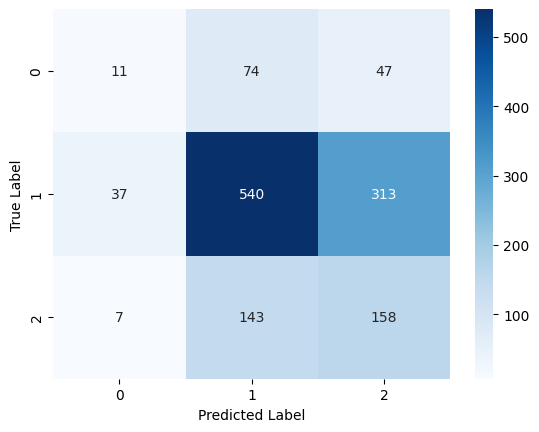

FPR  [0.         0.05388471 0.05401003 ... 0.33308271 0.33333333 0.33333333]
TPR  [0.         0.14235589 0.14411028 ... 0.33308271 0.33308271 0.33333333]
auc  0.07049940012939616


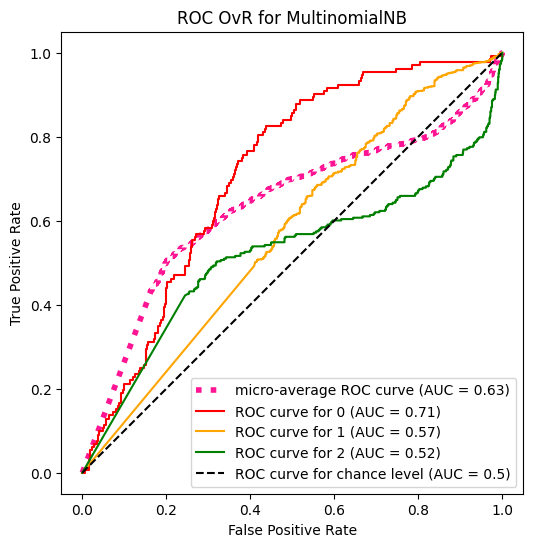

In [67]:
mnb(X_train, X_test, y_train, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.28      0.38       132
           1       0.72      0.82      0.77       890
           2       0.42      0.34      0.38       308

    accuracy                           0.66      1330
   macro avg       0.58      0.48      0.51      1330
weighted avg       0.64      0.66      0.64      1330

Confusion Matrix:

True Positive Rate (TPR):  [0.28030303 0.8247191  0.33766234]
False Positive Rate (FPR):  [0.02170284 0.65227273 0.13894325]


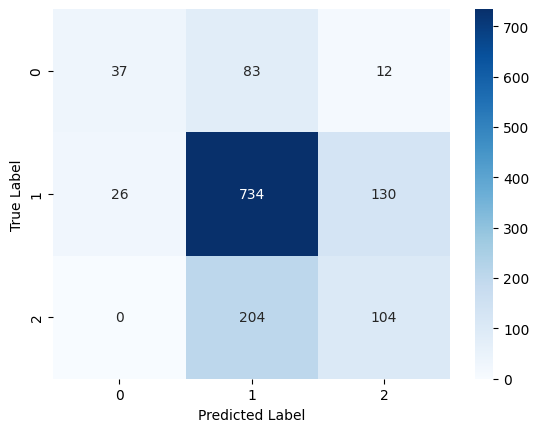

FPR  [0.00000000e+00 1.25313283e-04 1.25313283e-04 ... 3.29699248e-01
 3.29949875e-01 3.33333333e-01]
TPR  [0.         0.         0.00250627 ... 0.33333333 0.33333333 0.33333333]
auc  0.09109974183579247


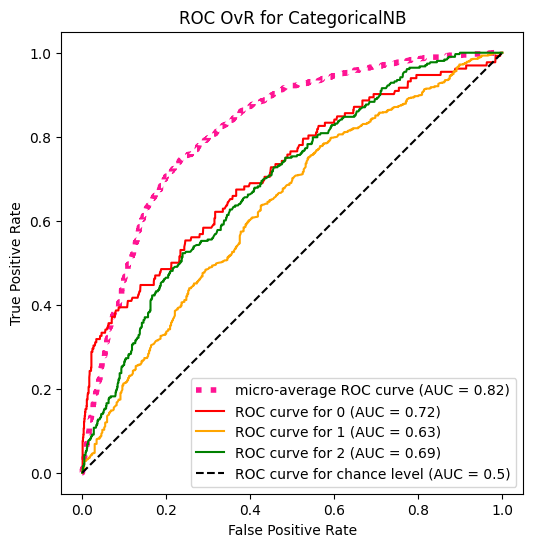

In [68]:
cnb(X_train, X_test, y_train, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       132
           1       0.68      0.96      0.80       890
           2       0.49      0.13      0.21       308

    accuracy                           0.67      1330
   macro avg       0.39      0.36      0.34      1330
weighted avg       0.57      0.67      0.58      1330

Confusion Matrix:

True Positive Rate (TPR):  [0.         0.95617978 0.13311688]
False Positive Rate (FPR):  [0.         0.89772727 0.04207436]


/var/folders/kv/0y3wx08169b3kd208_31935c0000gn/T/ipykernel_29954/4161075262.py:20: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)


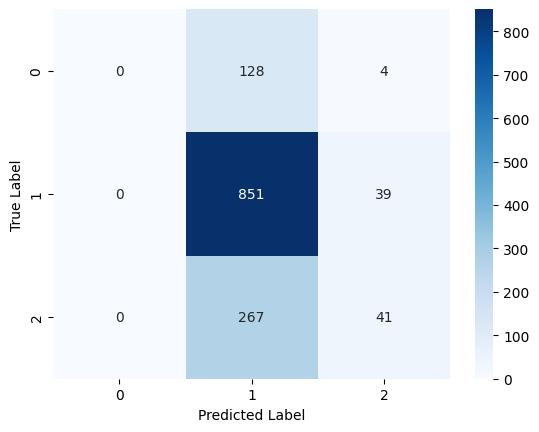

FPR  [0.00000000e+00 1.25313283e-04 1.25313283e-04 ... 3.25313283e-01
 3.33333333e-01 3.33333333e-01]
TPR  [0.         0.         0.00125313 ... 0.33308271 0.33308271 0.33333333]
auc  0.09384319193974912


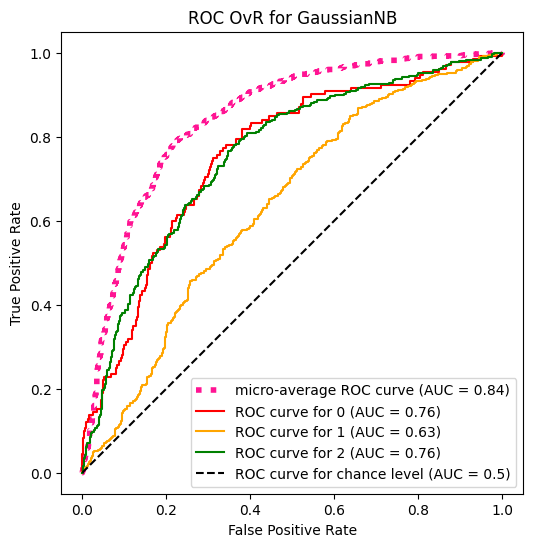

In [69]:
gnb(X_train, X_test, y_train, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.21      0.33       132
           1       0.74      0.93      0.82       890
           2       0.71      0.37      0.49       308

    accuracy                           0.73      1330
   macro avg       0.72      0.51      0.55      1330
weighted avg       0.73      0.73      0.70      1330

Confusion Matrix:

True Positive Rate (TPR):  [0.21212121 0.93483146 0.37012987]
False Positive Rate (FPR):  [0.01001669 0.675      0.04598826]


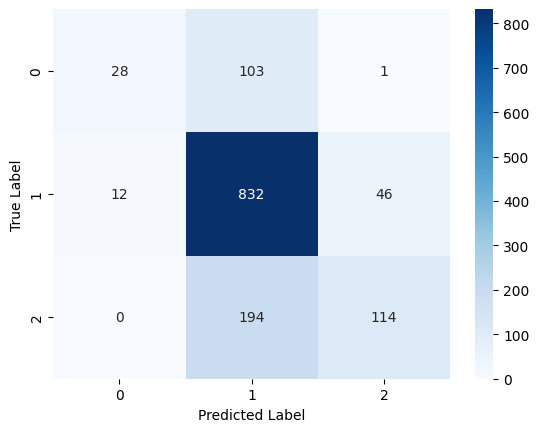

FPR  [0.         0.         0.         ... 0.32380952 0.32431078 0.33333333]
TPR  [0.00000000e+00 2.50626566e-04 2.95739348e-02 ... 3.33333333e-01
 3.33333333e-01 3.33333333e-01]
auc  0.09826731616007436


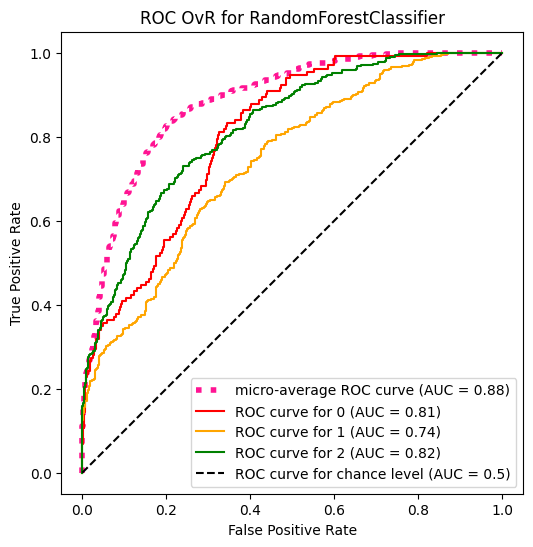

In [70]:
rf(X_train, X_test, y_train, y_test)